# Networks of organisations


  
* *Exploratory SNA* book's chapter 5 about 'Affiliations'
* Cf. [this notebook](https://github.com/Sciences-historiques-numeriques/histoire_numerique_methodes/blob/main/analyse_reseaux/pajek_book/chapter5_affiliations.ipynb) 



In [1]:
### Librairie à installer dans l'environnement conda (si on exécute en local)
# qui sera choisi pour exécuter le carnet

%matplotlib inline

from SPARQLWrapper import SPARQLWrapper, JSON, TURTLE, XML, RDFXML
import pandas as pd

import scipy.stats as stats

import networkx as nx
from networkx.algorithms import bipartite

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import numpy as np
import seaborn as sns
import math
import os

In [2]:
### Librairies déjà installées avec Python
import pprint
import csv

import sqlite3 as sql

import time
import datetime
from dateutil import parser


from shutil import copyfile


In [3]:
### Importer un module de fonctions crées ad hoc
##  ATTENTION : le fichier 'sparql_functions.py' doit se trouver 
#   dans un dossier qui se situe dans le chemin ('path') de recherche
#   vu par le présent carnet Jupyter afin que
#   l'importation fonctionne correctement

import sys
from importlib import reload

# Add parent directory to the path
sys.path.insert(0, '..')

### If you want to add the parent-parent directory,
sys.path.insert(0, '../..')


import sparql_functions as spqf
import network_analysis_functions as naf

In [4]:
print(reload(naf))  

<module 'network_analysis_functions' from 'c:\\Users\\laila\\OneDrive\\Documents\\Uni\\2e année\\Semestre 4\\Application de méthodes numériques pour les sciences humaines et historiques\\French_CEOs\\notebooks_jupyter\\wikidata_exploration\\network_analysis_functions.py'>


## Get the data from the triplestore

This notebook is based on the same relationships (and therefore data) as [the one about persons' relationships](wdt_persons_organisations_networks.ipynb), namely the relationship between persons and organisations as original information.

Here, however, we will focus on relationships between institutions, so the treatment is different.


In [5]:
## define SPARQL enpoint
endpoint = "https://ag15yee0az6rmk64.allegrograph.cloud/repositories/ceos"

In [6]:
query = """

PREFIX franzOption_defaultDatasetBehavior: <franz:rdf>
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX crm: <http://www.cidoc-crm.org/cidoc-crm/>
PREFIX wikibase: <http://wikiba.se/ontology#>
PREFIX bd: <http://www.bigdata.com/rdf#>


SELECT ?person (MIN(?pLabel) AS ?personLabel)
        (MIN(?birthYear) AS ?birthYear)
        ?relationship 
        ?organisation (MIN(?oLabel) AS ?organisationLabel)
        (COUNT(*) as ?n) 
        (GROUP_CONCAT(DISTINCT ?groupTypeLabel; separator=" | ") AS ?groupTypes) 
        #(GROUP_CONCAT(DISTINCT ?countryLabel; separator=" | ") AS ?countries) 

WHERE {
        GRAPH <https://github.com/Laillaa/French_CEOs/blob/main/graphs/Wikidata-imported-data.md>
        {
        {?person a wd:Q5;
           rdfs:label ?pLabel;
           wdt:P569 ?birthYear.
        }


        {?person wdt:P108 ?organisation.
        BIND('employment' AS ?relationship)
        }   
        UNION
        {?person wdt:P463 ?organisation.
        BIND('membership' AS ?relationship)
        }   
        UNION
        {?person wdt:P69 ?organisation.
        BIND('education' AS ?relationship)
        }  
        ?organisation rdfs:label ?oLabel;
                # instance of
                wdt:P31 ?groupType.
        ?groupType rdfs:label ?groupTypeLabel         
        
        # OPTIONAL {
        #    ?organisation wdt:P17 ?country.
        #    ?country rdfs:label ?countryLabel.
        # }

         }        



    }

GROUP BY ?person ?relationship ?organisation   
ORDER by ?person 
"""

In [7]:
### Executer la requête avec les fonctions de la librairie locale
try:
    qr = spqf.get_json_sparql_result(endpoint,query)
    out = [l for l in spqf.sparql_result_to_list(qr)]
    print(len(out))
    pprint.pprint(out[100:103])
except Exception as e:
    print(e)    


3839
[['http://www.wikidata.org/entity/Q105693319',
  'Laurent Prud’homme',
  '1974',
  'membership',
  'http://www.wikidata.org/entity/Q131137989',
  'emlyon alumni',
  '2',
  'alumni association | organization'],
 ['http://www.wikidata.org/entity/Q105693319',
  'Laurent Prud’homme',
  '1974',
  'education',
  'http://www.wikidata.org/entity/Q1795504',
  'Emlyon Business School',
  '1',
  'grande école'],
 ['http://www.wikidata.org/entity/Q105693319',
  'Laurent Prud’homme',
  '1974',
  'education',
  'http://www.wikidata.org/entity/Q662976',
  'Panthéon-Assas University Paris',
  '1',
  'university in France']]


## Inspect the data


In [8]:
### Créer un DataFrame à partir du résultat
df_p = pd.DataFrame(out)
df_p.columns = ['uriPer', 'labelPer', 'birthYear', 'relaType', 'uriOrg', 'labelOrg', 'nTypes',
                'typesOrg']
print('Number: ',len(df_p))
df_p.iloc[10:13,:]


Number:  3839


,uriPer,labelPer,birthYear,relaType,uriOrg,labelOrg,nTypes,typesOrg
10,http://www.wikidata.org/entity/Q100997694,Jean-Luc Chetrit,1965,education,http://www.wikidata.org/entity/Q1795504,Emlyon Business School,1,grande école
11,http://www.wikidata.org/entity/Q101112672,Markus Krah,1968,education,http://www.wikidata.org/entity/Q1688743,Jewish Theological Seminary of America,2,Jewish seminary | private not-for-profit educa...
12,http://www.wikidata.org/entity/Q101112672,Markus Krah,1968,education,http://www.wikidata.org/entity/Q168000,American University,3,private not-for-profit educational institution...


### Distribution of relationships in relation to birthYears of organisations members

In [9]:
l_50 = list(range(1761, 2051, 30))
print(l_50)

[1761, 1791, 1821, 1851, 1881, 1911, 1941, 1971, 2001, 2031]


In [10]:
### We adapt the periods manually,
# we would like to have eight periods
# making sense from an historical point of view 
lc = [1751, 1801, 1851, 1901, 1921, 1941, 1961, 1981, 2001]

In [11]:
### 30 years periods, but some customisations
lc = [1751, 1811, 1851, 1881, 1911, 1941, 1971, 2001]

In [12]:
### convert birthYear to integer
df_p.birthYear = df_p.birthYear.apply(lambda x : int(x))

In [13]:
### fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
# On ajoute une nouvelle colonne qui contient la période sur la base de la liste précédente
# et de la valeur de l'année
df_p['periods'] = pd.cut(df_p['birthYear'], lc, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
df_p['periods'] = df_p['periods'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
df_p.iloc[[1,5,10]]

,uriPer,labelPer,birthYear,relaType,uriOrg,labelOrg,nTypes,typesOrg,periods
1,http://www.wikidata.org/entity/Q100158636,Amanda Pritchard,1976,education,http://www.wikidata.org/entity/Q5316528,Durham Johnston Comprehensive School,2,secondary school | community school,1971-2000
5,http://www.wikidata.org/entity/Q100705519,Ponce,1991,education,http://www.wikidata.org/entity/Q3578313,École polytechnique universitaire de Montpellier,2,engineering college | grande école,1971-2000
10,http://www.wikidata.org/entity/Q100997694,Jean-Luc Chetrit,1965,education,http://www.wikidata.org/entity/Q1795504,Emlyon Business School,1,grande école,1941-1970


#### Reload from CSV

This is only possible if you already stored the data into a CSV, cf. below

In [14]:
### load from CSV

file_add = 'persons_organisations_from_organisations.csv'
df_p=pd.read_csv(file_add)
print(len(df_p))
df_p.head(2)


3839


,uriPer,labelPer,birthYear,relaType,uriOrg,labelOrg,nTypes,typesOrg,periods,listTypesOrg
0,http://www.wikidata.org/entity/Q100158636,Amanda Pritchard,1976,education,http://www.wikidata.org/entity/Q34433,University of Oxford,6,collegiate university | educational organizati...,1971-2000,"['collegiate university', 'educational organiz..."
1,http://www.wikidata.org/entity/Q100158636,Amanda Pritchard,1976,education,http://www.wikidata.org/entity/Q5316528,Durham Johnston Comprehensive School,2,community school | secondary school,1971-2000,"['community school', 'secondary school']"


In [15]:
### Group by periods
df_period = df_p.groupby(by='periods', observed=True).size()
print(df_period)

periods
1811-1850       7
1851-1880      17
1881-1910      89
1911-1940     291
1941-1970    2271
1971-2000    1164
dtype: int64


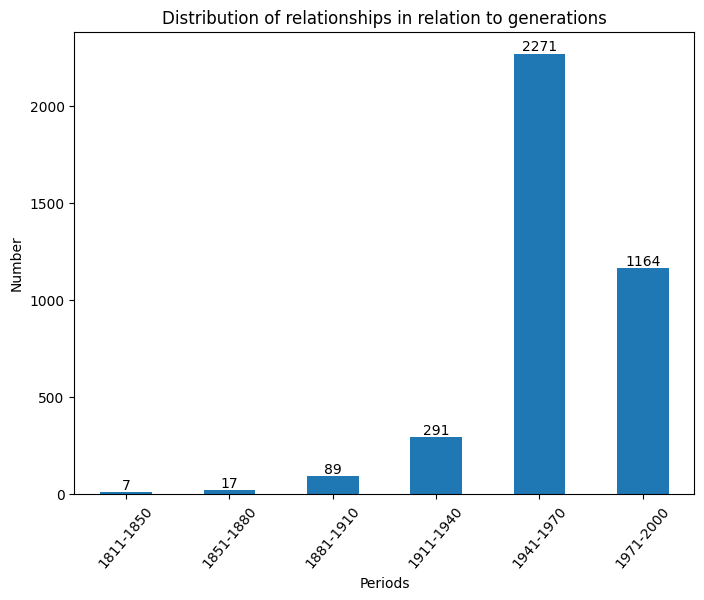

In [16]:
ax = df_period.plot(kind='bar',rot=50, fontsize=10, figsize=(8,6))
ax.bar_label(ax.containers[-1], size=10)
plt.ylabel('Number')
plt.xlabel('Periods')
plt.title('Distribution of relationships in relation to generations')
plt.show()

### Inspect available relationships

In [17]:
### Available relationships
print(df_p.groupby(by='relaType').size())

relaType
education     3288
employment     127
membership     424
dtype: int64


In [18]:
dfg_pr=df_p.groupby(by=['periods','relaType'], observed=True, as_index=False).size()
print(dfg_pr)

      periods    relaType  size
0   1811-1850   education     3
1   1811-1850  employment     2
2   1811-1850  membership     2
3   1851-1880   education    13
4   1851-1880  employment     1
5   1851-1880  membership     3
6   1881-1910   education    61
7   1881-1910  employment     6
8   1881-1910  membership    22
9   1911-1940   education   246
10  1911-1940  employment    19
11  1911-1940  membership    26
12  1941-1970   education  1982
13  1941-1970  employment    65
14  1941-1970  membership   224
15  1971-2000   education   983
16  1971-2000  employment    34
17  1971-2000  membership   147


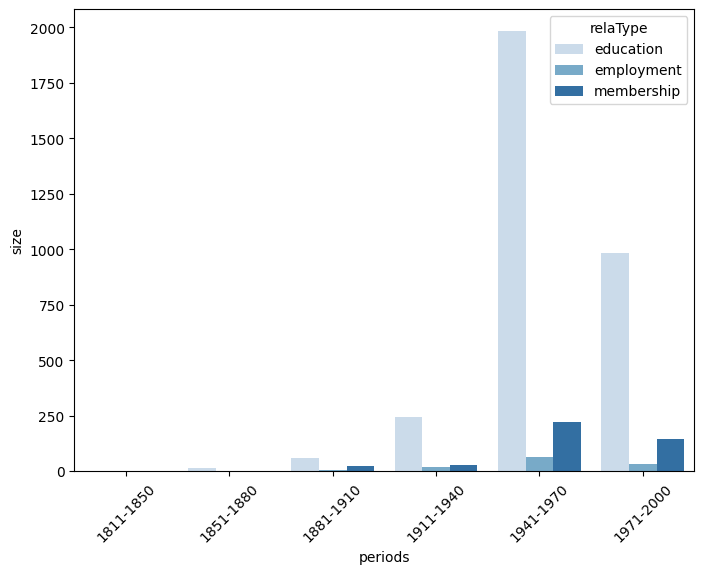

In [19]:
%matplotlib inline
plt.figure(figsize=(8, 6)) 
ax = sns.barplot(data=dfg_pr, x='periods', y='size', hue='relaType', palette='Blues')
ax.tick_params(axis='x', labelrotation=45)


### Clean up organisations type

In [20]:
### Transform types' strings to alphabetically sorted lists and delete additional white spaces
df_p['listTypesOrg'] = df_p.typesOrg.apply(lambda x : sorted([e.strip().lower() for e in x.split('|')]))

ll = df_p.listTypesOrg.to_list()
print(len(ll))
pprint.pprint(ll[:3])


3839
[['collegiate university',
  'educational organization',
  'exempt charity',
  'higher education institution',
  'organization',
  'public university'],
 ['community school', 'secondary school'],
 ['open-access publisher',
  'private not-for-profit educational institution',
  'private university',
  'research university']]


In [21]:
## Rebuild the sorted original texts after sorting
df_p['typesOrg'] = df_p.listTypesOrg.apply(lambda x : ' | '.join(x))
df_p.iloc[[1,5,10]]


,uriPer,labelPer,birthYear,relaType,uriOrg,labelOrg,nTypes,typesOrg,periods,listTypesOrg
1,http://www.wikidata.org/entity/Q100158636,Amanda Pritchard,1976,education,http://www.wikidata.org/entity/Q5316528,Durham Johnston Comprehensive School,2,community school | secondary school,1971-2000,"[community school, secondary school]"
5,http://www.wikidata.org/entity/Q100705519,Ponce,1991,education,http://www.wikidata.org/entity/Q3578313,École polytechnique universitaire de Montpellier,2,engineering college | grande école,1971-2000,"[engineering college, grande école]"
10,http://www.wikidata.org/entity/Q100997694,Jean-Luc Chetrit,1965,education,http://www.wikidata.org/entity/Q1795504,Emlyon Business School,1,grande école,1941-1970,[grande école]


#### Organisations' types distribution

In [22]:
print(df_p.groupby('typesOrg').size().sort_values(ascending=False).iloc[:10])

typesOrg
grande école                                                                                                     201
alumni association | organization                                                                                182
business school                                                                                                  175
high school                                                                                                      125
university                                                                                                       125
geographic location | university                                                                                  80
public university                                                                                                 72
colonial colleges | private not-for-profit educational institution | private university | research university     71
open-access publisher | ottoman association | universit

#### Save dataframe to CSV

In [23]:
file_add = '../persons_organisations_from_organisations.csv'
df_p.to_csv(file_add, index=False, sep=',', quotechar='"')

## Types of organisations

Property **wdt:P31 instance of**


We are trying to figure out if we can use these types to distinguish and categorise organisations. We will introduce high-level, research-driven classes that primarily serve a heuristic function and express no objective point of view.

In [24]:
### Inspect the available composed types
df_types = pd.DataFrame(df_p.groupby('typesOrg').size().sort_values(ascending=False))
df_types.reset_index(inplace=True)
df_types.columns=['typesOrg', 'number']
df_types['numberOrg'] = df_types.typesOrg.apply( lambda x: len(x.split('|')))
df_types.iloc[:10]

,typesOrg,number,numberOrg
0,grande école,201,1
1,alumni association | organization,182,2
2,business school,175,1
3,high school,125,1
4,university,125,1
5,geographic location | university,80,2
6,public university,72,1
7,colonial colleges | private not-for-profit edu...,71,4
8,open-access publisher | ottoman association | ...,68,3
9,school,61,1


In [25]:
### Print to CSV in order to inspect the data
csv_file='../network_organisations_types_groups.csv'
df_types.to_csv(csv_file)

### Add organisation main type

In [26]:
### Inspect the data
df_p.head(1)

,uriPer,labelPer,birthYear,relaType,uriOrg,labelOrg,nTypes,typesOrg,periods,listTypesOrg
0,http://www.wikidata.org/entity/Q100158636,Amanda Pritchard,1976,education,http://www.wikidata.org/entity/Q34433,University of Oxford,6,collegiate university | educational organizati...,1971-2000,"[collegiate university, educational organizati..."


In [27]:
def code_organisation_main_type(x):
    val = ''
    if 'institute of technol' in x:
        val = 'institute of technology'
    elif 'polyt' in x:
        val = 'institute of technology'    
    elif 'observato' in x:
        val = 'astronomical observatory'  
    elif 'public university' in x:
        val = 'public university'
    elif 'école normale sup' in x:
        val = 'public university'    
    elif 'grande école' in x:
        val = 'public university'
    elif 'grand établissement' in x:
        val = 'public university'
    elif 'private university' in x:
        val = 'private university'
    elif 'university' in x:
        val = 'university'   
    elif 'educational inst' in x:
        val = 'educational institution'    
    elif 'military academy' in x:
        val = 'educational institution' 
    elif 'naval academy' in x:
        val = 'educational institution'        
    elif 'art academy' in x:
        val = 'educational institution' 
    elif 'faculty' in x:
        val = 'university'  # could also be 'faculty'
    elif 'academic dep' in x:
        val =  'university'  # could also be 'faculty'    
    elif 'college' in x:
        val = 'educational institution'   # could also be 'college'             
    elif 'gymnas' in x:
        val = 'educational institution'   # could also be 'college'
    elif 'learned society' in x:
        val = 'learned society'     
    elif 'academy of sciences' in x:
        val = 'academy of sciences'
    elif 'research institute' in x:
        val = 'research organisation'
    elif 'max planck' in x:
        val = 'research organisation'
    elif 'institute' in x:
        val = 'research organisation' 
    elif 'research' in x:
        val = 'research organisation'
    elif 'laboratory' in x:
        val = 'research facility'  
    elif 'facility' in x:
        val = 'research facility'   
    elif 'scientific society' in x:
        val = 'scientific organisation'
    elif 'scientific society' in x:
        val = 'scientific organisation'
    elif 'museum' in x:
        val = 'scientific organisation'
    elif 'nonprofit organization' in x:
        val = 'scientific organisation'    
    elif 'national academy' in x:
        val = 'scientific organisation'
    elif 'scientific organization' in x:
        val = 'scientific organisation'
    elif 'higher education' in x:
        val = 'educational institution'
    elif 'school' in x:
        val = 'educational institution'   # could also be 'high school or similar'
    elif 'academic institution' in x:
        val = 'educational institution'   # could also be 'high school or similar'
    elif 'academy' in x:
        val = 'learned society'
    elif 'society' in x:
        val = 'learned society'      
    elif 'company' in x \
                or 'business'  in x \
                or 'entrepr' in x:
        val = 'company or gov. agency' # could also be 'company'
    elif 'government' in x :
        val = 'company or gov. agency' # could also be 'government agency'         
    elif 'publish' in x :
        val = 'company or gov. agency' # could also be 'publisher_edition'     
    elif 'journal' in x :
        val = 'company or gov. agency' # could also be 'publisher_edition'
    elif 'periodical' in x :
        val = 'company or gov. agency' # could also be 'publisher_edition'    
    else:
        val = 'not classified organisation'

    return val        

In [28]:
df_p['orgMainType'] = df_p['typesOrg'].apply(lambda x : code_organisation_main_type(x))
df_p.iloc[7:10]

,uriPer,labelPer,birthYear,relaType,uriOrg,labelOrg,nTypes,typesOrg,periods,listTypesOrg,orgMainType
7,http://www.wikidata.org/entity/Q100705519,Ponce,1991,education,http://www.wikidata.org/entity/Q916444,Cours Florent,2,drama school | educational institution,1971-2000,"[drama school, educational institution]",educational institution
8,http://www.wikidata.org/entity/Q100989426,Thomas Schäfer,1970,education,http://www.wikidata.org/entity/Q317070,University of Mannheim,2,organization | public university,1941-1970,"[organization, public university]",public university
9,http://www.wikidata.org/entity/Q100997694,Jean-Luc Chetrit,1965,membership,http://www.wikidata.org/entity/Q131137989,emlyon alumni,2,alumni association | organization,1941-1970,"[alumni association, organization]",not classified organisation


In [29]:
df_mainTypes = pd.DataFrame(df_p.groupby(by='orgMainType', as_index=False).size().sort_values(by='size',ascending=False))
df_mainTypes.columns=['mainType', 'number']
df_mainTypes

,mainType,number
11,university,1216
2,educational institution,998
7,public university,647
6,private university,385
5,not classified organisation,353
3,institute of technology,72
10,scientific organisation,55
4,learned society,40
8,research facility,26
1,company or gov. agency,24


In [30]:
### Inspect the available composed types
df_types = pd.DataFrame(df_p.groupby(['typesOrg', 'orgMainType'], as_index=False).\
                        size().sort_values(by='size',ascending=False))
df_types.columns=['typesOrg', 'orgMainType', 'number']
df_types['numberOrg'] = df_types.typesOrg.apply( lambda x: len(x.split('|')))
### Print to CSV in order to inspect the data
csv_file='../network_organisations_with_main_types_groups.csv'
df_types.to_csv(csv_file)

df_types.iloc[7:10]

,typesOrg,orgMainType,number,numberOrg
277,colonial colleges | private not-for-profit edu...,private university,71,4
622,open-access publisher | ottoman association | ...,university,68,3
740,school,educational institution,61,1


#### 'Manual' corrections and classification improvements

In some cases, instpecting the organisations shows that the provided classification is not suitable and should be replaced:

Academia Europaea, ...

We provide this example merely to illustrate the point; further work would be required, but this is beyond the scope of this exercise.

In [31]:
### Please note the warning and the orders fo the filter, after (!) the column 
"""
Do not use:
df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.
See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
"""

df_p.loc[df_p.uriOrg == 'http://www.wikidata.org/entity/Q337234', 'orgMainType'] = 'research organisation'
df_p[df_p.labelOrg.str.contains('Europaea')].head(2)



,uriPer,labelPer,birthYear,relaType,uriOrg,labelOrg,nTypes,typesOrg,periods,listTypesOrg,orgMainType
2726,http://www.wikidata.org/entity/Q5451129,Fiona Watt,1956,membership,http://www.wikidata.org/entity/Q337234,Academia Europaea,3,academy | charitable organization | organization,1941-1970,"[academy, charitable organization, organization]",research organisation


# Create graphs

In [32]:
### Available relationships
print(df_p.groupby(by='relaType').size())

relaType
education     3288
employment     127
membership     424
dtype: int64


### Prepare the dataframe

In [33]:
### Select the columns that will be used
df_prep = df_p[['uriPer','labelPer','birthYear','uriOrg', 'labelOrg', 'typesOrg', 'orgMainType', 'relaType', 'periods']].copy(deep=True)
print(len(df_prep))

3839


### Features of organisations

#### General grouping


We first group by organisations, counting all relationships of persons which provides the total degree or number of members over the whole time 

In [34]:
### Memberships by organisations
df_org = pd.DataFrame(df_prep.groupby(['uriOrg', 'labelOrg', 'typesOrg','orgMainType'],as_index=False).size())
df_org.columns=['uriOrg', 'labelOrg', 'typesOrg', 'orgMainType','tot_members_number']
df_org.sort_values('tot_members_number',ascending=False).iloc[:10]

,uriOrg,labelOrg,typesOrg,orgMainType,tot_members_number
495,http://www.wikidata.org/entity/Q1795504,Emlyon Business School,grande école,public university,191
235,http://www.wikidata.org/entity/Q131137989,emlyon alumni,alumni association | organization,not classified organisation,182
471,http://www.wikidata.org/entity/Q174158,Hebrew University of Jerusalem,geographic location | university,university,80
794,http://www.wikidata.org/entity/Q319239,Tel Aviv University,open-access publisher | ottoman association | ...,university,68
253,http://www.wikidata.org/entity/Q13371,Harvard University,colonial colleges | private not-for-profit edu...,private university,64
1050,http://www.wikidata.org/entity/Q49126,Harvard Business School,business school | organization,educational institution,49
919,http://www.wikidata.org/entity/Q41506,Stanford University,open-access publisher | private not-for-profit...,private university,44
828,http://www.wikidata.org/entity/Q333705,Technion – Israel Institute of Technology,publishing company | university,university,35
90,http://www.wikidata.org/entity/Q1124657,Bar-Ilan University,academic publisher | public research university,university,30
1236,http://www.wikidata.org/entity/Q591115,University of Haifa,public research university,university,25


In [35]:
### Save list of organisations as CSV
csv_file='../network_organisations_with_main_type_and_number.csv'
df_org.sort_values('tot_members_number',ascending=False).to_csv(csv_file)

#### Group by period

We then group by heuristic period (or generation)

In [36]:
df_orgPeriod = pd.DataFrame(df_prep.groupby(['uriOrg', 'labelOrg', 'orgMainType', 'periods']).size(), columns=['period_members_number'])
df_orgPeriod.reset_index(inplace=True)
df_orgPeriod.sort_values(by='periods', ascending=True).head()

,uriOrg,labelOrg,orgMainType,periods,period_members_number
2093,http://www.wikidata.org/entity/Q896468,Augsburg Technical University of Applied Sciences,public university,1811-1850,1
1911,http://www.wikidata.org/entity/Q7659951,Sydney Grammar School,educational institution,1811-1850,1
760,http://www.wikidata.org/entity/Q21777946,Société de géographie (Lyon),learned society,1811-1850,1
1154,http://www.wikidata.org/entity/Q41726,freemasonry,not classified organisation,1811-1850,1
911,http://www.wikidata.org/entity/Q28695,University of Helsinki,public university,1811-1850,2


#### Group by period and relationship type

We then group by heuristic period (or generation) AND relationship type, i.e. which kind of relationship associates a person to an organisation in the bipartite network

In [37]:
df_orgPeriodRelType = pd.DataFrame(df_prep.groupby(['uriOrg', 'labelOrg', 'orgMainType', 'relaType', 'periods']).size(), columns=['period_members_number'])
df_orgPeriodRelType.reset_index(inplace=True)
df_orgPeriodRelType.sort_values(by='period_members_number', ascending=False).head()

,uriOrg,labelOrg,orgMainType,relaType,periods,period_members_number
292,http://www.wikidata.org/entity/Q131137989,emlyon alumni,not classified organisation,membership,1941-1970,95
644,http://www.wikidata.org/entity/Q1795504,Emlyon Business School,public university,education,1941-1970,95
293,http://www.wikidata.org/entity/Q131137989,emlyon alumni,not classified organisation,membership,1971-2000,85
645,http://www.wikidata.org/entity/Q1795504,Emlyon Business School,public university,education,1971-2000,85
1045,http://www.wikidata.org/entity/Q319239,Tel Aviv University,university,education,1941-1970,50


In [38]:
### Number of relationships by period with type
dfgt = df_orgPeriodRelType.groupby(['periods', 'relaType'], as_index=False)\
    .sum('members').sort_values(['relaType', 'periods'])
file_addr='../organisations_types_periods_distribution.csv'
dfgt.sort_values(['relaType', 'periods']).to_csv(file_addr)
print(len(dfgt))
dfgt.iloc[:10]

18


,periods,relaType,period_members_number
0,1811-1850,education,3
3,1851-1880,education,13
6,1881-1910,education,61
9,1911-1940,education,246
12,1941-1970,education,1982
15,1971-2000,education,983
1,1811-1850,employment,2
4,1851-1880,employment,1
7,1881-1910,employment,6
10,1911-1940,employment,19


In [39]:
### Number of relationships without period
dfgw = df_orgPeriodRelType.groupby(['relaType' ], as_index=False)\
    .sum('members').sort_values([ 'relaType'])
print(len(dfgw))

3


## Bivariate analysis: relationship, organisation type

### Create the needed functions

In [40]:
### ct_m : contingency table without totals in margins
def bivariee_stats(ct_wm):
    
    
    n = ct_wm.sum().sum()

    ### Valeurs produites par la fonction de la librairie 'stats'
    statistic, p, dof, expected = stats.chi2_contingency(ct_wm)

    print('Chi2 :', statistic.round(2), ', dof :',dof)
    print('p-value :', p)

    

    print('phi2 = inertie (variance totale) :', statistic/n)


    ### Tableau à l'indépendance
    dfe = round(pd.DataFrame(expected),4)

    ### Coéfficient de Cramer
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

    vc = stats.contingency.association(ct_wm, method='cramer')
    print('Cramer: ', vc)

    return None





In [41]:
### ct_m : contingency tables with totals in margins
def plot_chi2_residuals(ct_wm, figsize=(9,3)):
    
    D = ct_wm

    
    ### Valeurs produites par la fonction de la librairie 'stats'
    statistic, p, dof, expected = stats.chi2_contingency(D)

    ### Situation à l'indépendance
    indep = pd.DataFrame(expected)
    indep.columns = D.columns
    indep.index = D.index

    ### Résidus pondérés (avec le signe)
    ### Doc. :
    #   Rakotomalala, p.240
    residus_ponderes = (round((D-indep)/np.sqrt(indep),2))
    ### Résidus pondérés
    tableau = residus_ponderes
   

    fig, ax = plt.subplots(figsize=figsize)         
    # Sample figsize in inches
    g = sns.heatmap(tableau, annot=tableau, cmap="coolwarm", linewidths=.5, ax=ax)
    xlabels = tableau.columns
    px = g.set_xticklabels(xlabels, rotation=60, size=8, 
                           ha='right', rotation_mode='anchor')
    ylabels = tableau.index
    py = g.set_yticklabels(ylabels, rotation=20, size=8)
    
    plt.show()

    return residus_ponderes

### Explore contingency table : types of relationships, types of organisations

In [42]:


### Contingency table
X = 'relaType'
Y = 'orgMainType'  

ddf = df_prep[[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf



relaType,education,employment,membership,Total
orgMainType,,,,
academy of sciences,0,1,13,14
company or gov. agency,3,7,14,24
educational institution,983,9,6,998
institute of technology,66,6,0,72
learned society,2,0,37,39
not classified organisation,39,9,305,353
private university,372,13,0,385
public university,615,31,1,647
research facility,26,0,0,26


In [43]:
ct_wm = ddf.iloc[:-1,:-1].copy(deep=True)
ct_wm

relaType,education,employment,membership
orgMainType,,,
academy of sciences,0,1,13
company or gov. agency,3,7,14
educational institution,983,9,6
institute of technology,66,6,0
learned society,2,0,37
not classified organisation,39,9,305
private university,372,13,0
public university,615,31,1
research facility,26,0,0


In [44]:
### We observe a strong relationship between these two variables

bivariee_stats(ct_wm)

Chi2 : 3242.08 , dof : 22
p-value : 0.0
phi2 = inertie (variance totale) : 0.8445123768668488
Cramer:  0.6498124255763539


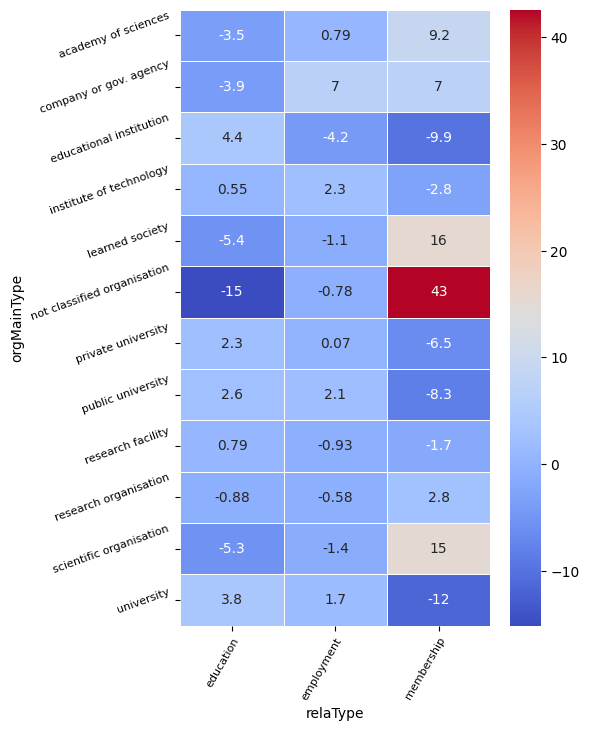

In [45]:
pp = plot_chi2_residuals(ct_wm, figsize=(5, 8))

#### Comment

We observe a strong relationship between these two variables which is explained by the fact that not all organisations types are concerned by the same relationship types

We also observe that some values should be corrected, like memberships in technical organisations that should be employments.

See the following example

In [46]:
pprint.pprint(list(df_p.loc[df_p.orgMainType.str.contains('techno') & df_p.relaType.str.contains('memb') ].items())[:6])

[('uriPer', Series([], Name: uriPer, dtype: object)),
 ('labelPer', Series([], Name: labelPer, dtype: object)),
 ('birthYear', Series([], Name: birthYear, dtype: int64)),
 ('relaType', Series([], Name: relaType, dtype: object)),
 ('uriOrg', Series([], Name: uriOrg, dtype: object)),
 ('labelOrg', Series([], Name: labelOrg, dtype: object))]


### Explore contingency table of relationships to organisations : periods, types of organisations

In [47]:
### Contingency table
X = 'periods'
Y = 'orgMainType'  

ddf = df_prep[[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf



periods,1811-1850,1851-1880,1881-1910,1911-1940,1941-1970,1971-2000,Total
orgMainType,,,,,,,
academy of sciences,0,0,2,3,7,2,14
company or gov. agency,0,1,2,2,12,7,24
educational institution,1,5,20,74,625,273,998
institute of technology,0,1,3,8,41,19,72
learned society,1,1,5,5,26,1,39
not classified organisation,1,2,7,19,177,147,353
private university,0,2,4,39,234,106,385
public university,4,2,17,22,355,247,647
research facility,0,0,0,0,9,17,26


In [48]:
ct_wm = ddf.iloc[:-1,:-1].copy(deep=True)

In [49]:
### We observe some not so strong relationship between these two variables
bivariee_stats(ct_wm)

Chi2 : 197.97 , dof : 55
p-value : 5.102620795634102e-18
phi2 = inertie (variance totale) : 0.051568245808937624
Cramer:  0.10155613798184493


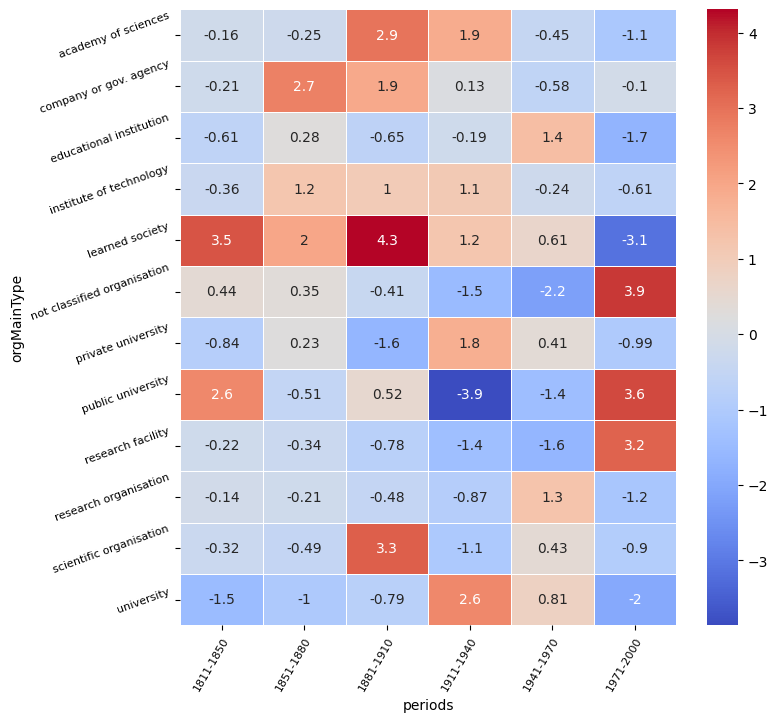

In [50]:
pp = plot_chi2_residuals(ct_wm, figsize=(8, 8))

### Explore contingency table of relationships to organisations : periods, types of relationships

In [51]:
### Contingency table
X = 'periods'
Y = 'relaType'  

ddf = df_prep[[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf



periods,1811-1850,1851-1880,1881-1910,1911-1940,1941-1970,1971-2000,Total
relaType,,,,,,,
education,3,13,61,246,1982,983,3288
employment,2,1,6,19,65,34,127
membership,2,3,22,26,224,147,424
Total,7,17,89,291,2271,1164,3839


In [52]:
ct_wm = ddf.iloc[:-1,:-1].copy(deep=True)

In [53]:
### We observe a relationship between these two variables, 
# not so strong 
bivariee_stats(ct_wm)

Chi2 : 58.05 , dof : 10
p-value : 8.449046397660199e-09
phi2 = inertie (variance totale) : 0.015121856944014123
Cramer:  0.08695359953450496


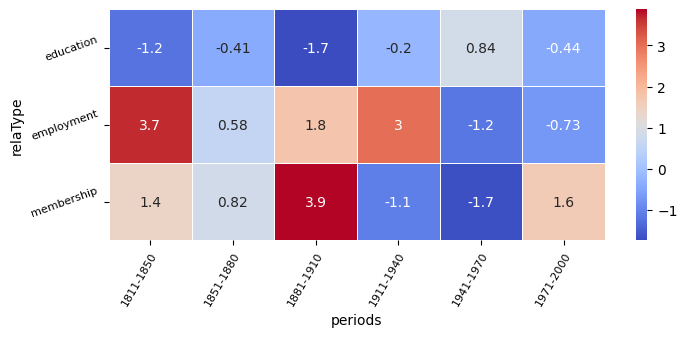

In [54]:
pp = plot_chi2_residuals(ct_wm, figsize=(8, 3))

### Explore contingency table of relationships to organisations : periods+types of relationships vs organisations types

In [55]:
df_prep['periods_relaType'] = df_prep.apply(lambda x : x.periods+'_'+x.relaType, axis=1)
df_prep.head(1)

,uriPer,labelPer,birthYear,uriOrg,labelOrg,typesOrg,orgMainType,relaType,periods,periods_relaType
0,http://www.wikidata.org/entity/Q100158636,Amanda Pritchard,1976,http://www.wikidata.org/entity/Q34433,University of Oxford,collegiate university | educational organizati...,public university,education,1971-2000,1971-2000_education


In [56]:
### Contingency table
X = 'periods_relaType'
Y = 'orgMainType'  

ddf = df_prep[[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf



periods_relaType,1811-1850_education,1811-1850_employment,1811-1850_membership,1851-1880_education,1851-1880_employment,1851-1880_membership,1881-1910_education,1881-1910_employment,1881-1910_membership,1911-1940_education,1911-1940_employment,1911-1940_membership,1941-1970_education,1941-1970_employment,1941-1970_membership,1971-2000_education,1971-2000_employment,1971-2000_membership,Total
orgMainType,,,,,,,,,,,,,,,,,,,
academy of sciences,0,0,0,0,0,0,0,0,2,0,0,3,0,0,7,0,1,1,14
company or gov. agency,0,0,0,1,0,0,0,1,1,0,1,1,1,3,8,1,2,4,24
educational institution,1,0,0,4,0,1,17,1,2,74,0,0,621,2,2,266,6,1,998
institute of technology,0,0,0,1,0,0,3,0,0,7,1,0,37,4,0,18,1,0,72
learned society,0,0,1,0,0,1,0,0,5,0,0,5,2,0,24,0,0,1,39
not classified organisation,0,0,1,0,1,1,0,0,7,3,0,16,19,6,152,17,2,128,353
private university,0,0,0,2,0,0,4,0,0,36,3,0,227,7,0,103,3,0,385
public university,2,2,0,2,0,0,15,2,0,19,3,0,336,19,0,241,5,1,647
research facility,0,0,0,0,0,0,0,0,0,0,0,0,9,0,0,17,0,0,26


In [57]:
ct_wm = ddf.iloc[:-1,:-1].copy(deep=True)

In [58]:
### We observe a relationship between these two variables, 
# not so strong 
bivariee_stats(ct_wm)

Chi2 : 3875.85 , dof : 187
p-value : 0.0
phi2 = inertie (variance totale) : 1.0095983382563212
Cramer:  0.30295489287055755


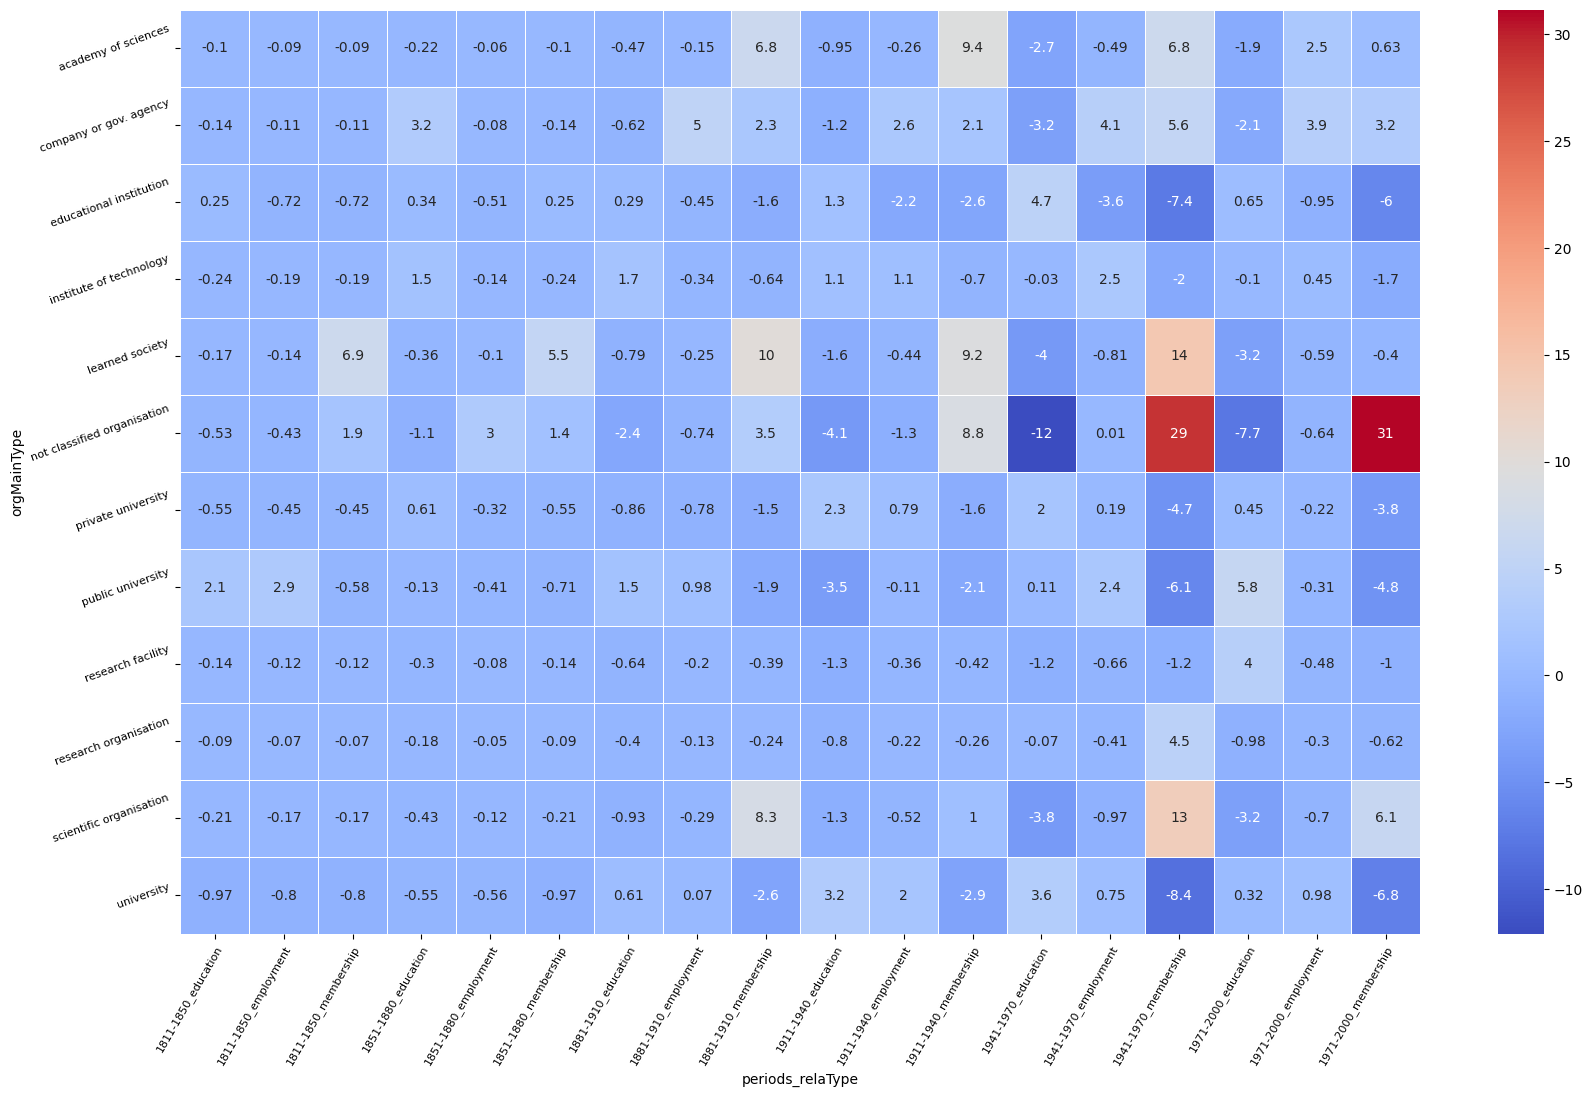

In [59]:
pp = plot_chi2_residuals(ct_wm, figsize=(20, 12))

## Prepare graph


In a heuristic perspective we take the persons as representing relationships among organisations.

Of course these relations are limited in time and with different meaning but in this general inspection of the field, we consider all the relationship. Filters are introduced later on.

We will create a projection of the graph on organisations and keep in a first stage all relationships, with types and periods, one per relationship, where the joining elements are those concerning uniquely the person

In [60]:
### Join on common organisation: Cartesian product -> produces a lot of rows !
merged = pd.merge(df_prep, df_prep, on=['uriPer','labelPer','birthYear', 'periods'])
print(len(merged))


11103


In [61]:
### Eliminate double rows :relationship A-B but relationship B-A
merged = merged[merged['uriOrg_x'] < (merged['uriOrg_y'])]


In [62]:
### Inspect
print(len(merged))
print(list(merged.columns))
merged.iloc[110:114]

3583
['uriPer', 'labelPer', 'birthYear', 'uriOrg_x', 'labelOrg_x', 'typesOrg_x', 'orgMainType_x', 'relaType_x', 'periods', 'periods_relaType_x', 'uriOrg_y', 'labelOrg_y', 'typesOrg_y', 'orgMainType_y', 'relaType_y', 'periods_relaType_y']


,uriPer,labelPer,birthYear,uriOrg_x,labelOrg_x,typesOrg_x,orgMainType_x,relaType_x,periods,periods_relaType_x,uriOrg_y,labelOrg_y,typesOrg_y,orgMainType_y,relaType_y,periods_relaType_y
359,http://www.wikidata.org/entity/Q106489525,Paul Hatte,1993,http://www.wikidata.org/entity/Q131137989,emlyon alumni,alumni association | organization,not classified organisation,membership,1971-2000,1971-2000_membership,http://www.wikidata.org/entity/Q3268614,Lycée Carnot,lycée | school building,educational institution,education,1971-2000_education
360,http://www.wikidata.org/entity/Q106489525,Paul Hatte,1993,http://www.wikidata.org/entity/Q131137989,emlyon alumni,alumni association | organization,not classified organisation,membership,1971-2000,1971-2000_membership,http://www.wikidata.org/entity/Q859363,Sciences Po,academic publisher | grand établissement | gra...,public university,education,1971-2000_education
362,http://www.wikidata.org/entity/Q106489525,Paul Hatte,1993,http://www.wikidata.org/entity/Q131137989,emlyon alumni,alumni association | organization,not classified organisation,membership,1971-2000,1971-2000_membership,http://www.wikidata.org/entity/Q546118,Paris-Sorbonne University - Paris IV,former educational institution | university in...,university,education,1971-2000_education
366,http://www.wikidata.org/entity/Q106595481,Marga Hoek,1965,http://www.wikidata.org/entity/Q214341,University of Amsterdam,research institute | university,university,education,1941-1970,1941-1970_education,http://www.wikidata.org/entity/Q633529,Erasmus University Rotterdam,organization | public university,public university,education,1941-1970_education


In [63]:
### Available ORIGINAL relationships
print(df_p.groupby(by='relaType').size())

relaType
education     3288
employment     127
membership     424
dtype: int64


In [64]:
### Number of relationships per type prepared for graph
gl_relaType = merged.groupby(['relaType_x', 'relaType_y'], as_index=False).size().sort_values(by='size', ascending=False)

gl_relaType


,relaType_x,relaType_y,size
0,education,education,2263
6,membership,education,644
2,education,membership,207
8,membership,membership,170
3,employment,education,119
1,education,employment,90
4,employment,employment,41
5,employment,membership,26
7,membership,employment,23


### Swap values in order to have the same orientation for all relationships

All relationships should have the same 'orientation', which is determined by alphabetical order:

education -> employment -> membership

In [65]:
### Example
df = pd.DataFrame({
    'column1': ['A', 'B', 'C', 'D'],
    'column2': ['X', 'Y', 'Z', 'W']
})

condition = df['column1'] < df['column2']
df.loc[condition, ['column1', 'column2']] = df.loc[condition, ['column2', 'column1']].values

print(df)

  column1 column2
0       X       A
1       Y       B
2       Z       C
3       W       D


In [66]:
### Test whether the relationship types are in the wrong alphabetical order.
condition = merged.relaType_x > merged.relaType_y

In [67]:
### Transpose under condition that the relation orientation is 'wrong',
# i.e. not according the alphabatical order

merged.loc[condition, 
    ['uriOrg_x','labelOrg_x','orgMainType_x','relaType_x', 'uriOrg_y','labelOrg_y','orgMainType_y','relaType_y']] = \
        merged.loc[condition,
    ['uriOrg_y','labelOrg_y','orgMainType_y','relaType_y','uriOrg_x','labelOrg_x','orgMainType_x','relaType_x']].values

In [68]:
### Inspect

merged.iloc[110:117]

,uriPer,labelPer,birthYear,uriOrg_x,labelOrg_x,typesOrg_x,orgMainType_x,relaType_x,periods,periods_relaType_x,uriOrg_y,labelOrg_y,typesOrg_y,orgMainType_y,relaType_y,periods_relaType_y
359,http://www.wikidata.org/entity/Q106489525,Paul Hatte,1993,http://www.wikidata.org/entity/Q3268614,Lycée Carnot,alumni association | organization,educational institution,education,1971-2000,1971-2000_membership,http://www.wikidata.org/entity/Q131137989,emlyon alumni,lycée | school building,not classified organisation,membership,1971-2000_education
360,http://www.wikidata.org/entity/Q106489525,Paul Hatte,1993,http://www.wikidata.org/entity/Q859363,Sciences Po,alumni association | organization,public university,education,1971-2000,1971-2000_membership,http://www.wikidata.org/entity/Q131137989,emlyon alumni,academic publisher | grand établissement | gra...,not classified organisation,membership,1971-2000_education
362,http://www.wikidata.org/entity/Q106489525,Paul Hatte,1993,http://www.wikidata.org/entity/Q546118,Paris-Sorbonne University - Paris IV,alumni association | organization,university,education,1971-2000,1971-2000_membership,http://www.wikidata.org/entity/Q131137989,emlyon alumni,former educational institution | university in...,not classified organisation,membership,1971-2000_education
366,http://www.wikidata.org/entity/Q106595481,Marga Hoek,1965,http://www.wikidata.org/entity/Q214341,University of Amsterdam,research institute | university,university,education,1941-1970,1941-1970_education,http://www.wikidata.org/entity/Q633529,Erasmus University Rotterdam,organization | public university,public university,education,1941-1970_education
367,http://www.wikidata.org/entity/Q106595481,Marga Hoek,1965,http://www.wikidata.org/entity/Q106661433,Q106661433,educational institution,educational institution,education,1941-1970,1941-1970_education,http://www.wikidata.org/entity/Q214341,University of Amsterdam,research institute | university,university,education,1941-1970_education
369,http://www.wikidata.org/entity/Q106595481,Marga Hoek,1965,http://www.wikidata.org/entity/Q106661433,Q106661433,educational institution,educational institution,education,1941-1970,1941-1970_education,http://www.wikidata.org/entity/Q633529,Erasmus University Rotterdam,organization | public university,public university,education,1941-1970_education
375,http://www.wikidata.org/entity/Q106621876,Susan Ruzenski,2000,http://www.wikidata.org/entity/Q49210,New York University,private not-for-profit educational institution...,private university,education,1971-2000,1971-2000_education,http://www.wikidata.org/entity/Q7691246,Teachers College,open-access publisher | private not-for-profit...,educational institution,education,1971-2000_education


In [69]:
### Number of relationships per type prepared for graph
gl_relaType = merged.groupby(['relaType_x', 'relaType_y'], as_index=False).size().sort_values(by='size', ascending=False)

gl_relaType


,relaType_x,relaType_y,size
0,education,education,2263
2,education,membership,851
1,education,employment,209
5,membership,membership,170
4,employment,membership,49
3,employment,employment,41


In [70]:
### Concat relationships
merged['relaType_concat'] = merged.apply(lambda x: x.relaType_x + '_' +x.relaType_y, axis=1)

In [71]:
print(list(merged.columns))
merged.iloc[110:112]


['uriPer', 'labelPer', 'birthYear', 'uriOrg_x', 'labelOrg_x', 'typesOrg_x', 'orgMainType_x', 'relaType_x', 'periods', 'periods_relaType_x', 'uriOrg_y', 'labelOrg_y', 'typesOrg_y', 'orgMainType_y', 'relaType_y', 'periods_relaType_y', 'relaType_concat']


,uriPer,labelPer,birthYear,uriOrg_x,labelOrg_x,typesOrg_x,orgMainType_x,relaType_x,periods,periods_relaType_x,uriOrg_y,labelOrg_y,typesOrg_y,orgMainType_y,relaType_y,periods_relaType_y,relaType_concat
359,http://www.wikidata.org/entity/Q106489525,Paul Hatte,1993,http://www.wikidata.org/entity/Q3268614,Lycée Carnot,alumni association | organization,educational institution,education,1971-2000,1971-2000_membership,http://www.wikidata.org/entity/Q131137989,emlyon alumni,lycée | school building,not classified organisation,membership,1971-2000_education,education_membership
360,http://www.wikidata.org/entity/Q106489525,Paul Hatte,1993,http://www.wikidata.org/entity/Q859363,Sciences Po,alumni association | organization,public university,education,1971-2000,1971-2000_membership,http://www.wikidata.org/entity/Q131137989,emlyon alumni,academic publisher | grand établissement | gra...,not classified organisation,membership,1971-2000_education,education_membership


In [72]:
df_graph=merged.groupby(['periods', 'relaType_concat', 'uriOrg_x', 'labelOrg_x', 'orgMainType_x',  
                         'uriOrg_y', 'labelOrg_y', 'orgMainType_y'],
               as_index=False)\
    .agg({'labelPer': '|'.join, 'uriPer': '|'.join})

df_graph['number'] = df_graph.labelPer.apply(lambda x : len(x.split('|')))


In [73]:
print(len(df_graph))
df_graph.sort_values('number',ascending=False).head()


3175


,periods,relaType_concat,uriOrg_x,labelOrg_x,orgMainType_x,uriOrg_y,labelOrg_y,orgMainType_y,labelPer,uriPer,number
1838,1941-1970,education_membership,http://www.wikidata.org/entity/Q1795504,Emlyon Business School,public university,http://www.wikidata.org/entity/Q131137989,emlyon alumni,not classified organisation,Jean-Luc Chetrit|Yann Bucaille-Lanrezac|Philip...,http://www.wikidata.org/entity/Q100997694|http...,95
2966,1971-2000,education_membership,http://www.wikidata.org/entity/Q1795504,Emlyon Business School,public university,http://www.wikidata.org/entity/Q131137989,emlyon alumni,not classified organisation,Barbara Belvisi|Bettina Ducat|Laurent Prud’hom...,http://www.wikidata.org/entity/Q105335639|http...,85
741,1941-1970,education_education,http://www.wikidata.org/entity/Q13371,Harvard University,private university,http://www.wikidata.org/entity/Q49126,Harvard Business School,educational institution,Michael Lynton|Rich Lesser|John Smith|Tim Sols...,http://www.wikidata.org/entity/Q14927550|http:...,14
967,1941-1970,education_education,http://www.wikidata.org/entity/Q174158,Hebrew University of Jerusalem,university,http://www.wikidata.org/entity/Q319239,Tel Aviv University,university,Michal Cohen|Shlomo Kramer|Q27990343|Jacob Per...,http://www.wikidata.org/entity/Q16340660|http:...,8
2993,1971-2000,education_membership,http://www.wikidata.org/entity/Q273535,HEC Paris,educational institution,http://www.wikidata.org/entity/Q112611146,HEC Alumni,not classified organisation,Valérie Baudson|Philippe Oddou|Norbert Fanchon...,http://www.wikidata.org/entity/Q106805862|http...,8


### Explore contingency table of relationship pairs to periods

In [74]:


### Contingency table
X = 'periods'
Y = 'relaType_concat'  

ddf = df_graph[[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf



periods,1811-1850,1851-1880,1881-1910,1911-1940,1941-1970,1971-2000,Total
relaType_concat,,,,,,,
education_education,0,3,23,147,1247,691,2111
education_employment,0,1,13,33,96,65,208
education_membership,0,3,46,41,312,198,600
employment_employment,0,0,1,2,18,20,41
employment_membership,1,0,11,3,19,14,48
membership_membership,0,0,67,9,49,42,167
Total,1,7,161,235,1741,1030,3175


In [75]:
ct_wm = ddf.iloc[:-1,:-1].copy(deep=True)

In [76]:
### We observe a relationship between these two variables, 
# not so strong 
bivariee_stats(ct_wm)

Chi2 : 641.0 , dof : 25
p-value : 3.2025574889093723e-119
phi2 = inertie (variance totale) : 0.20188936944959532
Cramer:  0.20094246412821523


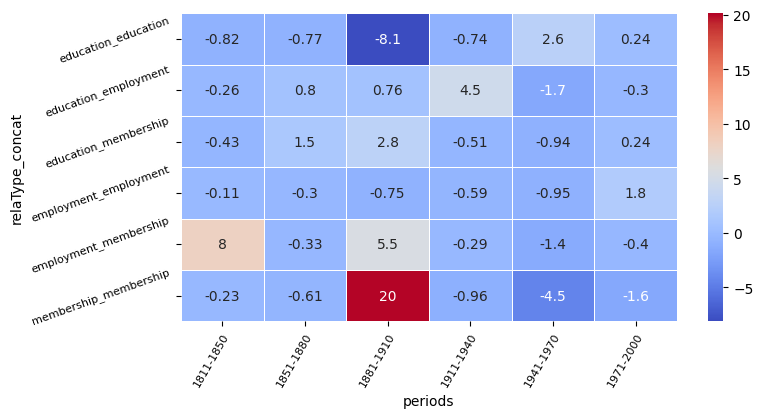

In [77]:
pp = plot_chi2_residuals(ct_wm, figsize=(8, 4))

## Graph analysis


We will explore some aspects of the relationships:

* which organisations are connected through education, but this only at the level of universities, not earlier education stages
* in the same perspective (same kind of relations), we will explore memberships and employments, keeping them separated
* we will then ask what appears regarding the relationship between employment and membership
* we finally inspect if some kind of educational institutions (at unversity level) lead to specific employments or memberships.






### Organisations connected through higher education

In [78]:
pprint.pprint(sorted(df_mainTypes.mainType.to_list()))

['academy of sciences',
 'company or gov. agency',
 'educational institution',
 'institute of technology',
 'learned society',
 'not classified organisation',
 'private university',
 'public university',
 'research facility',
 'research organisation',
 'scientific organisation',
 'university']


In [79]:
types_list=['university', 'public university', 'private university']

In [80]:
df_edu_graph = df_graph[(df_graph.relaType_concat == 'education_education') \
                     & (df_graph.orgMainType_x.isin(types_list)) \
                     & (df_graph.orgMainType_y.isin(types_list))  ]

print(len(df_edu_graph))
df_edu_graph.iloc[:2]

670


,periods,relaType_concat,uriOrg_x,labelOrg_x,orgMainType_x,uriOrg_y,labelOrg_y,orgMainType_y,labelPer,uriPer,number
9,1881-1910,education_education,http://www.wikidata.org/entity/Q131252,University of Chicago,private university,http://www.wikidata.org/entity/Q201492,McGill University,university,Chase G. Woodhouse,http://www.wikidata.org/entity/Q1067999,1
10,1881-1910,education_education,http://www.wikidata.org/entity/Q131252,University of Chicago,private university,http://www.wikidata.org/entity/Q20266894,University of Berlin,university,Chase G. Woodhouse,http://www.wikidata.org/entity/Q1067999,1


In [81]:
df_edu_graph.sort_values(by='number',ascending=False).iloc[:2]

,periods,relaType_concat,uriOrg_x,labelOrg_x,orgMainType_x,uriOrg_y,labelOrg_y,orgMainType_y,labelPer,uriPer,number
967,1941-1970,education_education,http://www.wikidata.org/entity/Q174158,Hebrew University of Jerusalem,university,http://www.wikidata.org/entity/Q319239,Tel Aviv University,university,Michal Cohen|Shlomo Kramer|Q27990343|Jacob Per...,http://www.wikidata.org/entity/Q16340660|http:...,8
2520,1971-2000,education_education,http://www.wikidata.org/entity/Q1795504,Emlyon Business School,public university,http://www.wikidata.org/entity/Q4027,Jean Moulin University - Lyon 3,university,Sylvain Boccon-Gibod|Christophe Dantoine|Sandr...,http://www.wikidata.org/entity/Q108598609|http...,7


In [82]:
### Number of relationships by period
print(df_edu_graph.groupby('periods').size())

periods
1881-1910     10
1911-1940     50
1941-1970    361
1971-2000    249
dtype: int64


### Inspect a specific period

In [83]:
p = '1881-1910' #'1851-1880' #'1911-1940'

In [84]:
df_edu_graph_p = df_edu_graph[(df_edu_graph.periods==p)]
df_edu_graph_p.sort_values(by='number',ascending=False).head(2)

,periods,relaType_concat,uriOrg_x,labelOrg_x,orgMainType_x,uriOrg_y,labelOrg_y,orgMainType_y,labelPer,uriPer,number
9,1881-1910,education_education,http://www.wikidata.org/entity/Q131252,University of Chicago,private university,http://www.wikidata.org/entity/Q201492,McGill University,university,Chase G. Woodhouse,http://www.wikidata.org/entity/Q1067999,1
10,1881-1910,education_education,http://www.wikidata.org/entity/Q131252,University of Chicago,private university,http://www.wikidata.org/entity/Q20266894,University of Berlin,university,Chase G. Woodhouse,http://www.wikidata.org/entity/Q1067999,1


In [85]:
l = [(
    e['uriOrg_x'], e['uriOrg_y'],
    {
        # No 'uriPer' or 'labelPer' in df_graph
        'weight': e['number']
    }
) for e in df_edu_graph_p.to_dict(orient='records')]
print(len(l))

10


In [86]:
edu_graph_p=nx.Graph()

## Add relationships to graph
# Multiple rows between two edges are taken only once
edu_graph_p.add_edges_from(l)

naf.basic_graph_properties(edu_graph_p)

### Create a list of graphs, one per component
edu_graph_p_S = [edu_graph_p.subgraph(c).copy() for c in nx.connected_components(edu_graph_p)]

### i is the component index in the list S of graphs , len(s.nodes) is the nomber of nodes
ln = sorted([[i,len(s.nodes)] for i,s in enumerate(edu_graph_p_S)], key = lambda row: row[1], reverse=True)
print(ln[:5])

{'is_multigraph': False,
 'is_directed': False,
 'number_of_nodes': 11,
 'number_of_edges': 10,
 '------': '------',
 'is connected': False,
 'components': 4,
 'density': 0.18181818181818182}
[[0, 3], [1, 3], [3, 3], [2, 2]]


In [87]:
### test if second component is significantly smaller 
# than first
if ln[1][1]*20 < ln[0][1]:
    print('Just one big component')
else :
    print('Beware: more than one big component !')    

Beware: more than one big component !


In [88]:
### Alternative way with just one graph
pG = edu_graph_p_S[0]
naf.basic_graph_properties(pG)

{'is_multigraph': False,
 'is_directed': False,
 'number_of_nodes': 3,
 'number_of_edges': 3,
 '------': '------',
 'is connected': True,
 'components': 1,
 'density': 1.0}


In [89]:
df_orgPeriod.sort_values(by='period_members_number', ascending=False).head(2)

,uriOrg,labelOrg,orgMainType,periods,period_members_number
617,http://www.wikidata.org/entity/Q1795504,Emlyon Business School,public university,1941-1970,101
277,http://www.wikidata.org/entity/Q131137989,emlyon alumni,not classified organisation,1941-1970,96


In [90]:
df_opl = df_orgPeriod[df_orgPeriod.periods==p][['uriOrg', 'labelOrg', 'orgMainType', 'period_members_number']]
df_opl.columns=['uri', 'label', 'mainType', 'membersNumber']
df_opl.head()


,uri,label,mainType,membersNumber
81,http://www.wikidata.org/entity/Q10861493,Krebs' Skole,educational institution,1
104,http://www.wikidata.org/entity/Q1122171,Brno University of Technology,university,1
124,http://www.wikidata.org/entity/Q1137665,Ghent University,public university,1
178,http://www.wikidata.org/entity/Q1189954,Mines ParisTech,public university,1
192,http://www.wikidata.org/entity/Q11989206,Metropolitanskolen,educational institution,2


In [91]:
### Prepare data to add to nodes
ln = dict([(e['uri'],
     {'label':e['label'], 'mainType':e['mainType'],
                        'membersNumber':e['membersNumber']}
     ) for e in df_opl.to_dict(orient='records')])
## Add attributes
nx.set_node_attributes(pG, ln)
pprint.pprint(list(pG.nodes.data())[:2])


[('http://www.wikidata.org/entity/Q201492',
  {'label': 'McGill University', 'mainType': 'university', 'membersNumber': 2}),
 ('http://www.wikidata.org/entity/Q20266894',
  {'label': 'University of Berlin',
   'mainType': 'university',
   'membersNumber': 1})]


In [92]:
mn_s = pd.Series([n[1]['mainType'] for n in pG.nodes.data()])
print(mn_s.groupby(by=mn_s).size().sort_values(ascending=False))

university            2
private university    1
dtype: int64


####  Create dataframe and inspect node properties

In [93]:
### Eigenvector
le = list(nx.eigenvector_centrality(pG, 
                        max_iter=200, weight='weight').items())
nx.set_node_attributes(pG, dict(le), 'eigenvector')
pprint.pprint(list(pG.nodes.data())[:1])

[('http://www.wikidata.org/entity/Q201492',
  {'eigenvector': 0.5773502691896258,
   'label': 'McGill University',
   'mainType': 'university',
   'membersNumber': 2})]


In [94]:
### Betweenness
lb = list(nx.betweenness_centrality(pG, weight='weight').items())
nx.set_node_attributes(pG, dict(lb), 'betweenness')
pprint.pprint(list(pG.nodes.data())[:1])


[('http://www.wikidata.org/entity/Q201492',
  {'betweenness': 0.0,
   'eigenvector': 0.5773502691896258,
   'label': 'McGill University',
   'mainType': 'university',
   'membersNumber': 2})]


In [95]:
### Export node attributes to dataframe
nodes_data ={node: pG.nodes[node] for node in pG.nodes}
nodes_df = pd.DataFrame(nodes_data).T
nodes_df.reset_index(inplace=True, names='id')
nodes_df.head(2)


,id,label,mainType,membersNumber,eigenvector,betweenness
0,http://www.wikidata.org/entity/Q201492,McGill University,university,2,0.57735,0.0
1,http://www.wikidata.org/entity/Q20266894,University of Berlin,university,1,0.57735,0.0


In [96]:
df_mainTypes

,mainType,number
11,university,1216
2,educational institution,998
7,public university,647
6,private university,385
5,not classified organisation,353
3,institute of technology,72
10,scientific organisation,55
4,learned society,40
8,research facility,26
1,company or gov. agency,24


In [97]:
### exclude less relevant or dirty classifications
lt=[t for t in df_mainTypes.mainType.to_list()
                if ('educat' not in t)  & ('classif' not in t)]
pprint.pprint(lt)

['university',
 'public university',
 'private university',
 'institute of technology',
 'scientific organisation',
 'learned society',
 'research facility',
 'company or gov. agency',
 'academy of sciences',
 'research organisation']


In [98]:
### source
# https://phrogz.net/css/distinct-colors.html
col_l = [c.strip() for c in '#ff0066, #0000ff, #00aaff,#beb6f2, #b6e6f2, #e6f2b6, #f2b6b6,#2d50b3, #ccff00, #8c005e, #8c8300'.split(',')]
print(col_l)

['#ff0066', '#0000ff', '#00aaff', '#beb6f2', '#b6e6f2', '#e6f2b6', '#f2b6b6', '#2d50b3', '#ccff00', '#8c005e', '#8c8300']


In [99]:
col_list= [e for e in zip(lt, col_l)]
print(col_list)

[('university', '#ff0066'), ('public university', '#0000ff'), ('private university', '#00aaff'), ('institute of technology', '#beb6f2'), ('scientific organisation', '#b6e6f2'), ('learned society', '#e6f2b6'), ('research facility', '#f2b6b6'), ('company or gov. agency', '#2d50b3'), ('academy of sciences', '#ccff00'), ('research organisation', '#8c005e')]


In [100]:
color_map=dict([(c[0], (c[1])) for c in col_list])
pprint.pprint(color_map)

{'academy of sciences': '#ccff00',
 'company or gov. agency': '#2d50b3',
 'institute of technology': '#beb6f2',
 'learned society': '#e6f2b6',
 'private university': '#00aaff',
 'public university': '#0000ff',
 'research facility': '#f2b6b6',
 'research organisation': '#8c005e',
 'scientific organisation': '#b6e6f2',
 'university': '#ff0066'}


In [101]:
### Manually modified list
color_map = {'academy of sciences': '#00aaff',
 'astronomical observatory': '#8c005e',
 'company or gov. agency': '#ccff00',
 'institute of technology': '#f2b6b6',
 'learned society': '#ff0066',
 'private university': '#ffcc00',
 'public university': '#8c8300',
 'research facility': '#d90000',
 'research organisation': '#beb6f2',
 'scientific organisation': '#2d50b3',
 'university': '#b6e6f2'}

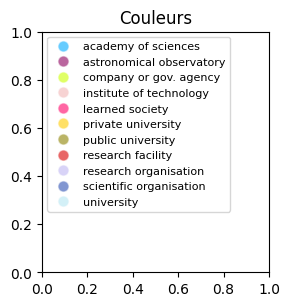

In [102]:

fig = plt.figure(figsize=(3,3))


### Create lists of colors and labels
colors = [color_map.keys()]
 

plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', 
                            label=label, markerfacecolor=color, 
                            markersize=8, alpha=0.6
                            ) for label, color in color_map.items() ],
                            loc='upper left', fontsize=8)
plt.tight_layout() # rect=[0,0,0.8,1]

plt.title('Couleurs')

plt.show()

In [103]:
### Create a function that plots the comparison between values and properties

def compare_with_scatter_plot(dataframe, value_1, value_2, point_column,point_ratio=1, 
                              c_category='', color_map='', figsize=(12,12), 
                              legend_loc='upper right',title='', 
                              n_label ='', label_cut_value=''):

    ### https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html
    # Different colors per class : https://vitalflux.com/python-scatter-plot-different-classes/
    # Legend : https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html
    # Labels : https://stackoverflow.com/questions/14432557/matplotlib-scatter-plot-with-different-text-at-each-data-point



    df=dataframe
    # df_extr=nodes_df[nodes_df.betweenness > 0].sort_values(by='betweenness', ascending=False)

    alpha=0.7

    ### Manage point colors:
    # https://kanoki.org/2020/08/30/matplotlib-scatter-plot-color-by-category-in-python/

    plt.figure(figsize=figsize)


    ### Create lists of colors and labels
    colors = [color_map[category] for category in df[c_category]]
 



    ax = plt.scatter(df[value_1],
                df[value_2],
            marker='o',
            s = [v*point_ratio for i,v in df[point_column].items()],
            color=colors,        
            alpha=alpha)
    plt.xlabel(value_1.capitalize())
    plt.ylabel(value_2.capitalize())






    ### Labels
    test_v1 = df[value_1].quantile([0.97]).item()
    test_v2 = df[value_2].quantile([0.95]).item()
    print(test_v1,test_v2)


    if len(n_label)>0:
        for i,row in list(df.loc[(df[value_1]>test_v1)|(df[value_2]>test_v2)]\
                          [[n_label,value_1,value_2]].iterrows()):
            plt.annotate(row[n_label][:30],(row[value_1], row[value_2]), fontsize=6)

    plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', 
                            label=label, markerfacecolor=color, 
                            markersize=8, alpha=alpha
                            ) for label, color in color_map.items() 
                                    if label in types_list ],
                            loc=legend_loc, fontsize=8)
    plt.tight_layout() # rect=[0,0,0.8,1]

    plt.title(title)

    # plt.savefig('plots/revenus_eigenvector_20210526.jpg')
    plt.show()

0.5773502691896258 0.0


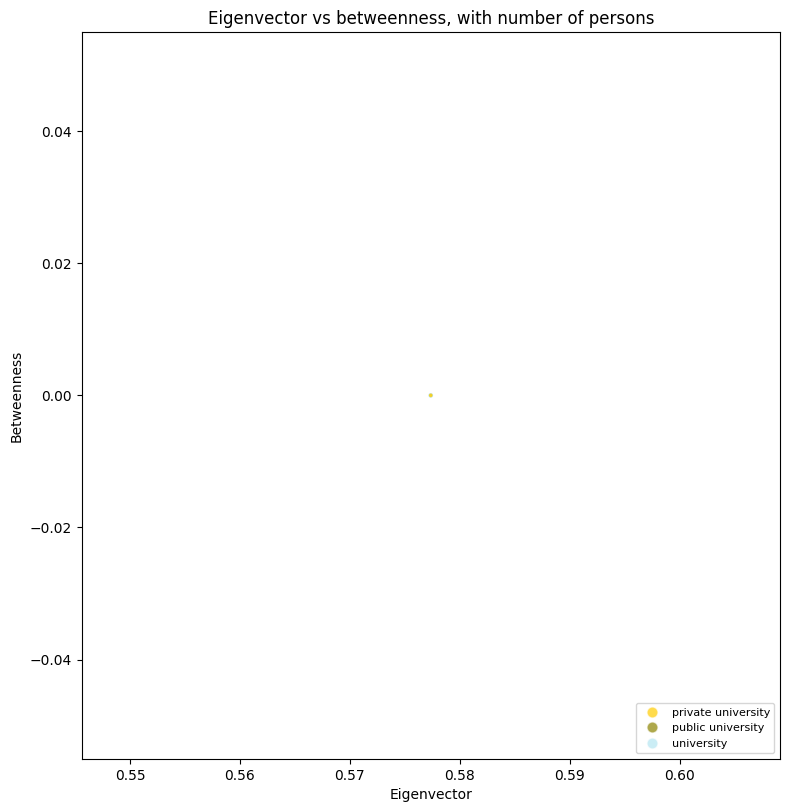

Spearman's rank correlation: nan


In [104]:
compare_with_scatter_plot(nodes_df, 'eigenvector', 'betweenness', 'membersNumber', 
                          point_ratio=3, c_category='mainType',
                          color_map=color_map, figsize=(8,8), 
                          legend_loc='lower right', 
                          title='Eigenvector vs betweenness, with number of persons', 
                          n_label='label', label_cut_value='membersNumber' )

corr_spear = nodes_df[['eigenvector', 'betweenness']].corr(method="spearman")
print("Spearman's rank correlation: {}".format(corr_spear.iloc[0,1]))

In [105]:
list(nodes_df.columns)

['id', 'label', 'mainType', 'membersNumber', 'eigenvector', 'betweenness']

In [106]:
print('Betweenness')
pprint.pprint((nodes_df.sort_values(by='betweenness', ascending=False)[['label', 'mainType', 'membersNumber']].head(7)))
print('\n-----\nEigenvector')
pprint.pprint((nodes_df.sort_values(by='eigenvector', ascending=False)[['label', 'mainType', 'membersNumber']].head(7)))

Betweenness
                   label            mainType membersNumber
0      McGill University          university             2
1   University of Berlin          university             1
2  University of Chicago  private university             1

-----
Eigenvector
                   label            mainType membersNumber
0      McGill University          university             2
1   University of Berlin          university             1
2  University of Chicago  private university             1


#### Plot graph

In [107]:
pict_addr = 'edu_edu_' + p +'.svg'
print(pict_addr)

edu_edu_1881-1910.svg


In [108]:
### Plot the graph

g = pG
# n_size = np.log(np.sqrt(nx.number_of_nodes(g)))* 25 #*25
n_size = np.log(nx.number_of_nodes(g))*10

graph_layout = 'spring_layout'
n_k = np.log(nx.number_of_nodes(g))/20 #2.5

### Define the layout, i.e. the choice 
# of the algorithm for the representation of the graph.

if graph_layout == 'fruchterman_reingold':
    pos = nx.fruchterman_reingold_layout(g)
elif graph_layout == 'kamada_kawai':
    pos = nx.kamada_kawai_layout(g)
elif graph_layout == 'spring_layout':
    pos = nx.spring_layout(g, k = n_k)  
else:
    pos = nx.kamada_kawai_layout(g)

# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (n_size,n_size))

node_size = [n[1]['membersNumber']*20 for n in g.nodes.data()]
#node_size = [d[1]*100 for d in nx.degree(g)]
node_colors= [color_map[n[1]['mainType']] for n in g.nodes.data()]

edge_size = [e[2]['weight'] for e in g.edges.data()]
edge_labels = {e: g.get_edge_data(e[0], e[1])["weight"] for e in g.edges()}

node_labels = dict([tuple(( n[0] , n[1]['label'] )) for n in g.nodes.data()])


nx.draw_networkx_nodes(g, pos, node_size=node_size, node_color=node_colors, alpha=0.6)
nx.draw_networkx_edges(g, pos, width=edge_size, alpha=0.02) # edgelist=ln, edge_color=c, 
nx.draw_networkx_labels(g, pos, labels=node_labels, alpha=0.7, font_size=10)
#nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels, alpha=0.7, font_size=10)

alpha_n=0.5

plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', 
                        label=label, markerfacecolor=color, 
                        markersize=12, alpha=alpha_n
                        )
                        for label, color in color_map.items()
                        if label in types_list ],
                        loc='lower right', fontsize=12)


### On peut augmenter ou diminuer ce paramètre pour ajuster le graphe
plt.tight_layout(pad=60)
pict_addr = pict_addr
plt.savefig(pict_addr)
#plt.show()
plt.close()


C:\Users\laila\AppData\Local\Temp\ipykernel_13496\452596361.py:52: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(pad=60)


### Communitites

In [109]:
l_communities = [(c, len(c)) for c in list(nx.community.louvain_communities(pG, resolution=0.7, weight='weight'))]
print( len(l_communities))
sl_communities = sorted(l_communities, key=lambda x: x[1], reverse=True)
print([c[1] for c in sl_communities])
print(sl_communities[-1:])


1
[3]
[({'http://www.wikidata.org/entity/Q201492', 'http://www.wikidata.org/entity/Q20266894', 'http://www.wikidata.org/entity/Q131252'}, 3)]


In [110]:
for i in range(min(5, len(sl_communities))):
    print('\n\nCommunity '+ str(i), '\nBetweenness')
    pprint.pprint(
        nodes_df[nodes_df.id.isin(list(sl_communities[i][0]))]
        .sort_values(by='betweenness', ascending=False)[['label', 'mainType', 'membersNumber']]
        .head(4)
    )
    print('\n-----\nEigenvector')
    pprint.pprint(
        nodes_df[nodes_df.id.isin(list(sl_communities[i][0]))]
        .sort_values(by='eigenvector', ascending=False)[['label', 'mainType', 'membersNumber']]
        .head(4)
    )



Community 0 
Betweenness
                   label            mainType membersNumber
0      McGill University          university             2
1   University of Berlin          university             1
2  University of Chicago  private university             1

-----
Eigenvector
                   label            mainType membersNumber
0      McGill University          university             2
1   University of Berlin          university             1
2  University of Chicago  private university             1


#### Plot communitites graph

In [111]:
pict_addr_comm = 'edu_edu_communities_' + p +'.svg'
print(pict_addr_comm)

edu_edu_communities_1881-1910.svg


In [112]:
### Plot the graph

g = pG
# n_size = np.log(np.sqrt(nx.number_of_nodes(g)))* 25 #*25
n_size = np.log(nx.number_of_nodes(g))*10

graph_layout = 'spring_layout'
n_k = np.log(nx.number_of_nodes(g))/20 #2.5

### Define the layout, i.e. the choice 
# of the algorithm for the representation of the graph.

if graph_layout == 'fruchterman_reingold':
    pos = nx.fruchterman_reingold_layout(g)
elif graph_layout == 'kamada_kawai':
    pos = nx.kamada_kawai_layout(g)
elif graph_layout == 'spring_layout':
    pos = nx.spring_layout(g, k = n_k)  
else:
    pos = nx.kamada_kawai_layout(g)

# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (n_size,n_size))

node_size = [n[1]['membersNumber']*20 for n in g.nodes.data()]
#node_size = [d[1]*100 for d in nx.degree(g)]

node_colors = []
for n in g.nodes.data():
    if n[0] in list(sl_communities[0][0]):
        node_colors.append('red')
    elif n[0] in list(sl_communities[1][0]):
        node_colors.append('blue')
    elif n[0] in list(sl_communities[2][0]):
        node_colors.append('green')
    elif n[0] in list(sl_communities[3][0]):
        node_colors.append('orange')
    elif n[0] in list(sl_communities[4][0]):
        node_colors.append('maroon')
    else:
        node_colors.append('lightGrey')        


edge_size = [e[2]['weight'] for e in g.edges.data()]
edge_labels = {e: g.get_edge_data(e[0], e[1])["weight"] for e in g.edges()}

node_labels = dict([tuple(( n[0] , n[1]['label'] )) for n in g.nodes.data()])


nx.draw_networkx_nodes(g, pos, node_size=node_size, node_color=node_colors, alpha=0.6)
nx.draw_networkx_edges(g, pos, width=edge_size, alpha=0.02) # edgelist=ln, edge_color=c, 
nx.draw_networkx_labels(g, pos, labels=node_labels, alpha=0.7, font_size=10)
#nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels, alpha=0.7, font_size=10)

alpha_n=0.5



### On peut augmenter ou diminuer ce paramètre pour ajuster le graphe
plt.tight_layout(pad=60)
pict_addr = pict_addr_comm
plt.savefig(pict_addr)
#plt.show()
plt.close()


C:\Users\laila\AppData\Local\Temp\ipykernel_13496\2935194816.py:60: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(pad=60)


## Create general function

In [117]:
def generate_report_and_plots(df, concatRelaType, type_list, doc_addr, df_orgPeriod):

    with open(doc_addr, "w") as myfile:
        myfile.write('# Report for relations: ' + concatRelaType + '\n')


    df_g = df[(df.relaType_concat == concatRelaType) \
                     & (df.orgMainType_x.isin(type_list)) \
                     & (df.orgMainType_y.isin(type_list))  ]

    txt = str(df_g.groupby('periods').size())

    with open(doc_addr, "a") as myfile:
        myfile.write('\n'+txt + '\n')

    for p in df_g['periods'].unique():
        print(str(p))   

        with open(doc_addr, "a") as myfile:
            myfile.write('\n\n\n## Values for ' + p + '\n')

        df_g_p = df_g[df_g.periods==p]
        
        with open(doc_addr, "a") as myfile:
            myfile.write('\nNumber of relationships for this period ' + str(len(df_g_p)) + '\n')
        
        l = [tuple(
            (e['uriOrg_x'], e['uriOrg_y'],
            {'uriPers':e['uriPer'], 'labelPers':e['labelPer'],
            ## the weight ist the number of persons in this relationship
            'weight':e['number']}
            )) 
            for e in df_g_p.to_dict(orient='records')]
        
        graph_p=nx.Graph()
        graph_p.add_edges_from(l)

        txt = 'Number of nodes: ' + str(graph_p.number_of_nodes())+\
                '\nNumber of edges: ' + str(graph_p.number_of_edges())
        with open(doc_addr, "a") as myfile:
                    myfile.write('\n'+ txt  + '\n')

        ### Components
        graph_p_S = [graph_p.subgraph(c).copy() 
                     for c in nx.connected_components(graph_p)]

        ln = sorted([[i,len(s.nodes)] for i,s in enumerate(graph_p_S)], key = lambda row: row[1], reverse=True)
        try:
            if ln[1][1]*20 < ln[0][1]:
                with open(doc_addr, "a") as myfile:
                    myfile.write('\nJust one big component with ' + str(graph_p_S[0].number_of_nodes()) + ' nodes\n')            
            else :
                with open(doc_addr, "a") as myfile:
                    myfile.write('\nBeware: more than one big component !'  + '\n')
        except Exception as e:
             print(e)            
            
        ### Alternative way with just one graph
        pG = graph_p_S[0]

        txt = 'Number of nodes for first component: ' + str(pG.number_of_nodes())+\
                '\nNumber of edges for first component: ' + str(pG.number_of_edges())
        with open(doc_addr, "a") as myfile:
                    myfile.write('\n'+ txt  + '\n')

        ### No treatment for smaller graphs
        if int(pG.number_of_nodes()) > 30:

            ### Prepare data to add to nodes

            df_opl = df_orgPeriod[df_orgPeriod.periods==p][['uriOrg', 'labelOrg', 'orgMainType', 'period_members_number']]
            df_opl.columns=['uri', 'label', 'mainType', 'membersNumber']

            ln = dict([(e['uri'],
                {'label':e['label'], 'mainType':e['mainType'],
                                    'membersNumber':e['membersNumber']}
                ) for e in df_opl.to_dict(orient='records')])
            ## Add attributes
            nx.set_node_attributes(pG, ln)

            mn_s = pd.Series([n[1]['mainType'] for n in pG.nodes.data()])
            txt= str(list(mn_s.groupby(by=mn_s).size().sort_values(ascending=False).items()))
            with open(doc_addr, "a") as myfile:
                    myfile.write('\n'+ txt  + '\n')

            ### Eigenvector
            try:
                le = list(nx.eigenvector_centrality(pG, 
                                        max_iter=1000, weight='weight').items())
            except Exception as e:
                print(e)    
            nx.set_node_attributes(pG, dict(le), 'eigenvector')   

            ### Betweenness
            lb = list(nx.betweenness_centrality(pG, weight='weight').items())
            nx.set_node_attributes(pG, dict(lb), 'betweenness')


            ### Export node attributes to dataframe
            nodes_data ={node: pG.nodes[node] for node in pG.nodes}
            nodes_df = pd.DataFrame(nodes_data).T
            nodes_df.reset_index(inplace=True, names='id')

            corr_spear = nodes_df[['eigenvector', 'betweenness']].corr(method="spearman")
            txt = "Spearman's rank correlation of eidenvector and betweenness: {}".format(corr_spear.iloc[0,1])
            with open(doc_addr, "a") as myfile:
                    myfile.write('\n'+ txt  + '\n')

            txt = 'Eigenvector\n' + \
                str(nodes_df.sort_values(by='eigenvector', ascending=False)[['label', 'mainType', 'membersNumber']].head(7) )+\
                '\n-----\nBetweenness'+\
                str(nodes_df.sort_values(by='betweenness', ascending=False)[['label', 'mainType', 'membersNumber']].head(7))
            with open(doc_addr, "a") as myfile:
                    myfile.write('\n'+ txt  + '\n')


            pict_addr = concatRelaType + '_' + p +'.svg'        


            ### Plot the graph
            g = pG
            # n_size = np.log(np.sqrt(nx.number_of_nodes(g)))* 25 #*25
            n_size = np.log(nx.number_of_nodes(g))*10

            graph_layout = 'spring_layout'
            n_k = np.log(nx.number_of_nodes(g))/20 #2.5

            ### Define the layout, i.e. the choice 
            # of the algorithm for the representation of the graph.

            if graph_layout == 'fruchterman_reingold':
                pos = nx.fruchterman_reingold_layout(g)
            elif graph_layout == 'kamada_kawai':
                pos = nx.kamada_kawai_layout(g)
            elif graph_layout == 'spring_layout':
                pos = nx.spring_layout(g, k = n_k)  
            else:
                pos = nx.kamada_kawai_layout(g)

            # https://networkx.org/documentation/stable/reference/drawing.html
            plt.figure(figsize = (n_size,n_size))

            node_size = [n[1]['membersNumber']*20 for n in g.nodes.data()]
            #node_size = [d[1]*100 for d in nx.degree(g)]
            #node_colors= [color_map[n[1]['mainType']] for n in g.nodes.data()]

            edge_size = [e[2]['weight'] for e in g.edges.data()]
            edge_labels = {e: g.get_edge_data(e[0], e[1])["weight"] for e in g.edges()}

            node_labels = dict([tuple(( n[0] , n[1]['label'] )) for n in g.nodes.data()])


            nx.draw_networkx_nodes(g, pos, node_size=node_size, node_color='blue', alpha=0.6)
            nx.draw_networkx_edges(g, pos, width=edge_size, alpha=0.02) # edgelist=ln, edge_color=c, 
            nx.draw_networkx_labels(g, pos, labels=node_labels, alpha=0.7, font_size=10)
            #nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels, alpha=0.7, font_size=10)

            alpha_n=0.5

            plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', 
                                    label=label, markerfacecolor=color, 
                                    markersize=8, alpha=alpha_n
                                    )
                                    for label, color in color_map.items()],
                                    loc='lower right', fontsize=8)


            ### On peut augmenter ou diminuer ce paramètre pour ajuster le graphe
            plt.tight_layout(pad=60)
            pict_addr = pict_addr
            plt.savefig(pict_addr)
            #plt.show()
            plt.close()


            ### Identify communitites
            l_communities = [(c, len(c)) for c in list(nx.community.louvain_communities(pG, resolution=0.7, weight='weight'))]
            sl_communities = sorted(l_communities, key=lambda x: x[1], reverse=True)
            txt= 'Number of communitites: ' + str(len(l_communities)) +\
                    '\nNumber of nodes per community: ' + str([c[1] for c in sl_communities])
            with open(doc_addr, "a") as myfile:
                myfile.write('\n'+ txt  + '\n')

            communities_print = 'Communities: \n'
            try:
                for i in range(0,5):
                    communities_print += '\n\nCommunity '+ str(i) + '\nBetweenness'
                    communities_print += str(nodes_df[nodes_df.id.isin(list(sl_communities[i][0])) ]\
                                                .sort_values(by='betweenness', ascending=False)[['label', 'mainType', 'membersNumber']].head(5).to_markdown())
                    communities_print += '\n-----\nEigenvector'
                    communities_print += str(nodes_df[nodes_df.id.isin(list(sl_communities[i][0])) ].sort_values(by='eigenvector', ascending=False)[['label', 'mainType', 'membersNumber']].head(5).to_markdown())
                with open(doc_addr, "a") as myfile:
                    myfile.write('\n'+ communities_print  + '\n')
            except Exception as e:
                 print(e)        

        else:
            print('Too small graph to be analyzed!')        


In [118]:
print(df_mainTypes.mainType.to_list())

['university', 'educational institution', 'public university', 'private university', 'not classified organisation', 'institute of technology', 'scientific organisation', 'learned society', 'research facility', 'company or gov. agency', 'academy of sciences', 'research organisation']


In [122]:
relationship_type = 'education_education'
generate_report_and_plots(df_graph, relationship_type,
                           ['university','public university','private university'],
                           'analysis_doc/'+relationship_type+'.md',
                           df_orgPeriod)

1881-1910
Too small graph to be analyzed!
1911-1940
Too small graph to be analyzed!
1941-1970
Missing optional dependency 'tabulate'.  Use pip or conda to install tabulate.
1971-2000
Too small graph to be analyzed!


In [123]:
relationship_type = 'membership_membership'
generate_report_and_plots(df_graph, relationship_type,
                           ['university',
                            'public university',
                            'academy of sciences',
                            'learned society',
                            'private university',
                            'research organisation',
                            'institute of technology',
                            'scientific organisation',
                            'astronomical observatory',
                            'research facility',
                            'company',
                            'governmenmt agency',
                            'publisher_edition'],
                           'analysis_doc/'+ relationship_type+'.md',
                           df_orgPeriod)

1881-1910
Too small graph to be analyzed!
1941-1970
Too small graph to be analyzed!
1971-2000
list index out of range
Too small graph to be analyzed!


In [124]:
relationship_type = 'employment_employment'
generate_report_and_plots(df_graph, relationship_type,
                           ['university',
                            'public university',
                            'academy of sciences',
                            'learned society',
                            'private university',
                            'research organisation',
                            'institute of technology',
                            'scientific organisation',
                            'astronomical observatory',
                            'research facility',
                            'company',
                            'governmenmt agency',
                            'publisher_edition'],
                           'analysis_doc/'+ relationship_type+'.md',
                           df_orgPeriod)

1911-1940
list index out of range
Too small graph to be analyzed!
1941-1970
Too small graph to be analyzed!
1971-2000
Too small graph to be analyzed!
